In [1]:
import os
import seaborn as sb
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'

🔵 *** df: dataframe ***
🟣 shape: (6_433, 14) columns: ['pickup', 'dropoff', 'passengers', 'distance', 'fare', 'tip', 'tolls', 'total', 'color', 'payment', 'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough'] 
🟣 duplicates: 0
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
--- column uniques (all)
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53, ]
🟠 dropoff(6_425|datetime64[ns]) [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48, ]
🟠 passengers(7|int64) [0, 1, 2, 3, 4,]
🟠 distance(1_079|float64) [0.0, 0.01, 0.02, 0.03, 0.04,]
🟠 fare(220|float64) [1.0, 2.5, 3.0, 3.5, 4.0,]
🟠 tip(489|float64) [0.0, 0.01, 0.02, 0.06, 0.08,]
🟠 tolls(16|float64) [0.0, 2.64, 4.75, 5.54, 5.75,]
🟠 total(898|float64) [1.3,

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


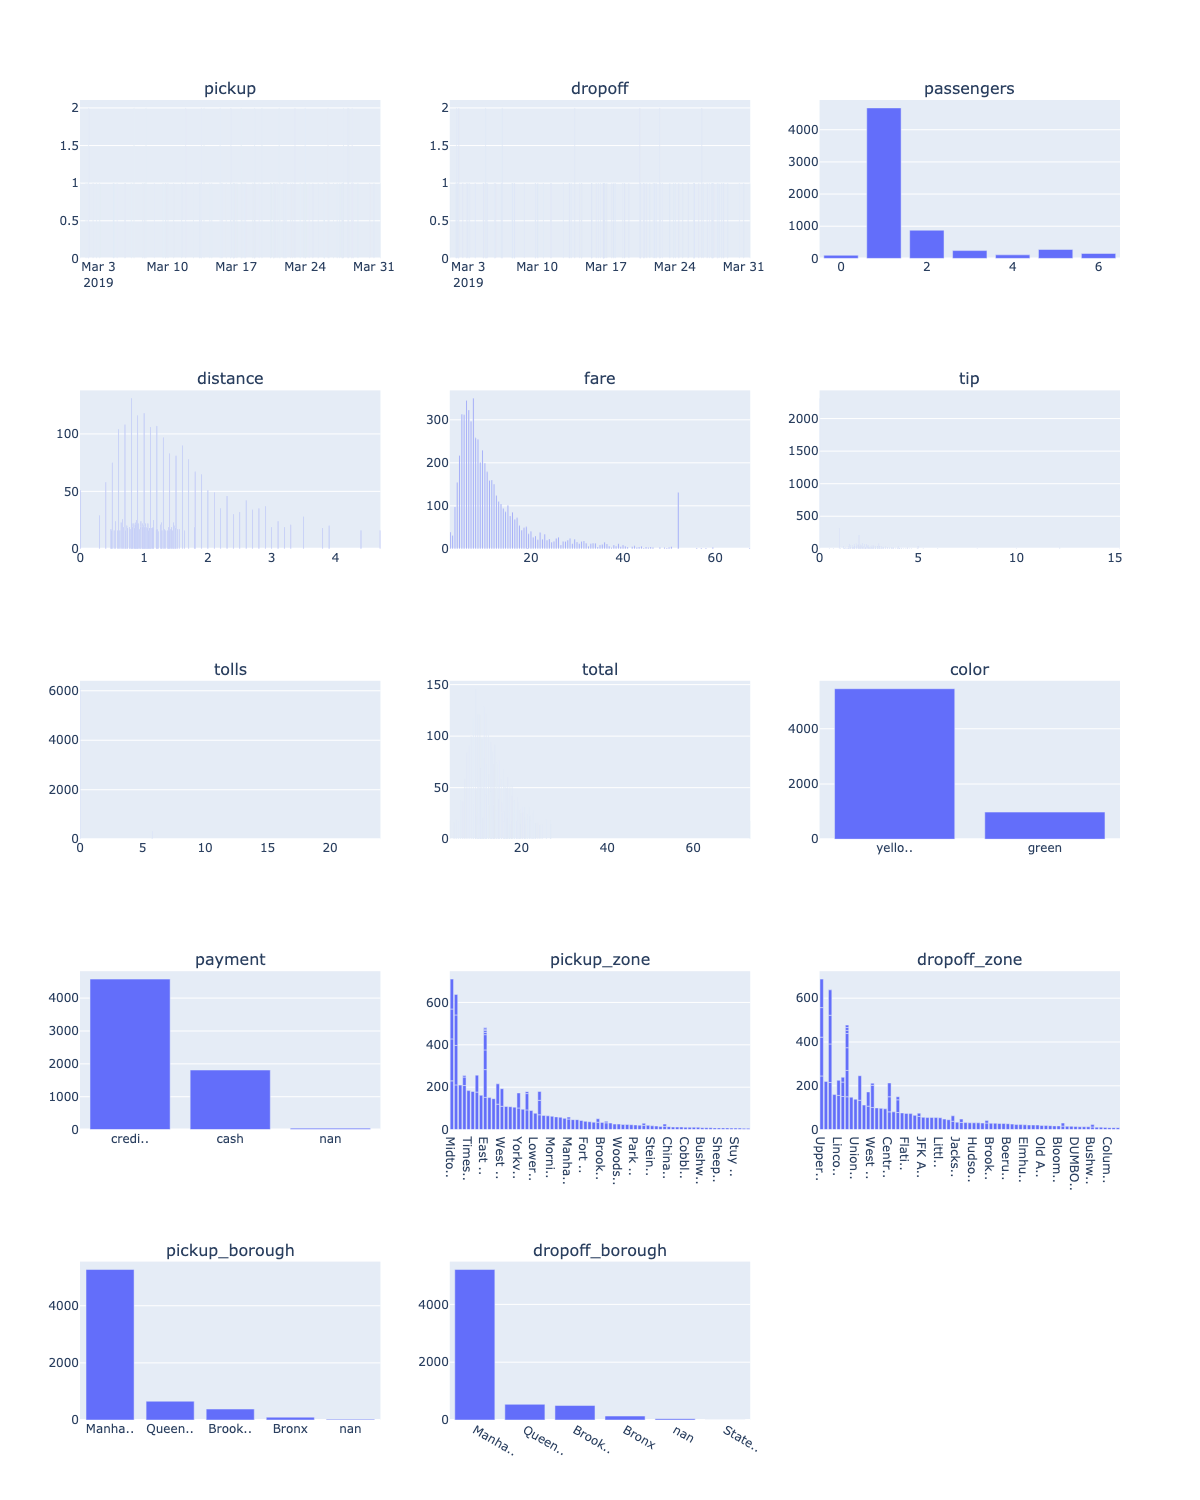

In [2]:
from pandas_plots import tbl, txt
tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

abc --> pick | drop | borough --> len: 217
ab --> pick | drop --> len: 213
ac --> pick | borough --> len: 198
bc --> drop | borough --> len: 207


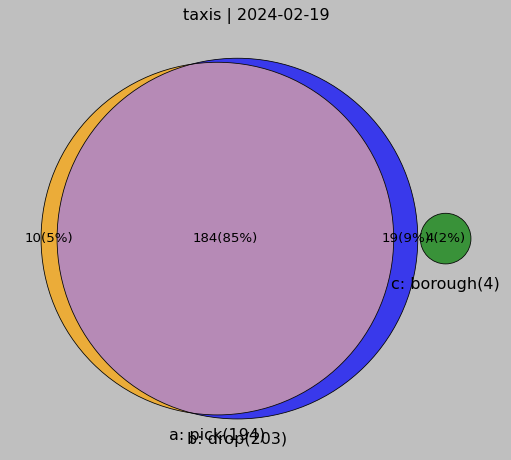

In [3]:
from pandas_plots import ven

set_a = set(df.pickup_zone)
set_b = set(df.dropoff_zone)
set_c = set(df['pickup_borough'])
_df, _details = ven.show_venn3(
    "taxis",
    set_a,
    "pick",
    set_b,
    "drop",
    c_set=set_c,
    c_label="borough",
    verbose=0,
    size=8,
)

In [7]:
import pandas as pd

_df=df[['passengers', 'distance', 'fare', 'tip', 'tolls','color' ]][:5]
tbl.show_df(_df.iloc[:,:-1], axis="x", show_totals=True, show_bars=True, show_pct=True, precision=0)
# _df.info()
# pd.api.types.is_numeric_dtype(_df)

,passengers,distance,fare,tip,tolls
0,1 (14.3%),2 (11.7%),7 (12.6%),2 (18.3%),0
1,1 (14.3%),1 (5.8%),5 (9.0%),0,0
2,1 (14.3%),1 (10.1%),8 (13.5%),2 (20.1%),0
3,1 (14.3%),8 (56.5%),27 (48.6%),6 (52.3%),0
4,3 (42.9%),2 (15.9%),9 (16.2%),1 (9.4%),0
Total,7 (100.0%),14 (100.0%),56 (100.0%),12 (100.0%),0
